In [147]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import tensorflow as tf
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [42]:
tf.keras.backend.set_learning_phase(0)

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Pre-Processing


In [148]:
artist_csv = pd.read_csv('../data/artists.csv')

#remove artists with multiple genres
artist_csv = artist_csv[~artist_csv["genre"].str.contains(",")].reset_index()
artist_csv["genre"] = artist_csv["genre"].str.replace(" ", "_")
artist_csv = artist_csv[["name", "genre", "paintings"]]
artist_csv 

#transform artitst_csv to a df with columns: genre, total paintings per genre 
genre_csv = artist_csv.groupby("genre").sum().reset_index()
genre_csv["class_weight"] = genre_csv["paintings"].max() / genre_csv["paintings"]
genre_csv.sort_values("paintings", ascending=False)

,genre,paintings,class_weight
7,Impressionism,1370,1.000000
12,Post-Impressionism,1048,1.307252
10,Northern_Renaissance,680,2.014706
1,Baroque,586,2.337884
3,Cubism,439,3.120729
16,Romanticism,388,3.530928
13,Primitivism,309,4.433657
6,High_Renaissance,301,4.551495
18,Surrealism,241,5.684647
5,Expressionism,193,7.098446


In [154]:
#get names of genres where paintings 200 or more
genre_csv = genre_csv[genre_csv["paintings"] >= 200]
genre_names = genre_csv["genre"].to_list()
genre_csv


,level_0,index,genre,paintings,class_weight
0,0,1,Baroque,586,2.337884
1,1,3,Cubism,439,3.120729
2,2,6,High_Renaissance,301,4.551495
3,3,7,Impressionism,1370,1.000000
4,4,10,Northern_Renaissance,680,2.014706
5,5,12,Post-Impressionism,1048,1.307252
6,6,13,Primitivism,309,4.433657
7,7,16,Romanticism,388,3.530928
8,8,18,Surrealism,241,5.684647


In [155]:
class_weights = genre_csv["class_weight"].to_dict()
# class_weights = {i: v for i, v in enumerate(class_weights.values())}
class_weights

{0: 2.3378839590443685,
 1: 3.120728929384966,
 2: 4.5514950166112955,
 3: 1.0,
 4: 2.014705882352941,
 5: 1.3072519083969465,
 6: 4.433656957928803,
 7: 3.5309278350515463,
 8: 5.6846473029045645}

## Data Agumentation

In [156]:
#hyperparameters
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = genre_csv.shape[0]

img_dir = '../data/genre_images/'

train_datagen = ImageDataGenerator(
                                   validation_split=0.2, 
                                   rescale=1./255., 
                                   shear_range=5,
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)

train_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    class_mode='categorical',
                                                    classes=genre_names,
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    shuffle=True,)

valid_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    class_mode='categorical',
                                                    classes=genre_names,
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset='validation',
                                                    shuffle=True,)

                                                    
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Numberr of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)                                           


Found 4220 images belonging to 9 classes.
Found 1051 images belonging to 9 classes.
Numberr of batches = 131 and 32


### Model


In [157]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [161]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = tf.keras.layers.LeakyReLU()(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = tf.keras.layers.LeakyReLU()(X)

output = Dense(len(genre_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [162]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['categorical_accuracy'],
)

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [86]:
n_epoch = 10

In [87]:
with tf.device("/gpu:0"):
    m = model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=n_epoch,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        batch_size=batch_size,
    )

Epoch 1/10
86/86 [==============================] - 488s 6s/step - loss: 1.3568 - categorical_accuracy: 0.5804 - val_loss: 3.1245 - val_categorical_accuracy: 0.0685
Epoch 2/10
86/86 [==============================] - 526s 6s/step - loss: 0.8652 - categorical_accuracy: 0.8083 - val_loss: 2.3845 - val_categorical_accuracy: 0.0833
Epoch 3/10
86/86 [==============================] - 530s 6s/step - loss: 0.6939 - categorical_accuracy: 0.8780 - val_loss: 2.2995 - val_categorical_accuracy: 0.1295
Epoch 4/10
86/86 [==============================] - 619s 7s/step - loss: 0.5957 - categorical_accuracy: 0.9061 - val_loss: 2.2837 - val_categorical_accuracy: 0.1339
Epoch 5/10
86/86 [==============================] - 587s 7s/step - loss: 0.4992 - categorical_accuracy: 0.9405 - val_loss: 2.3447 - val_categorical_accuracy: 0.1042
Epoch 6/10
86/86 [==============================] - 784s 9s/step - loss: 0.4486 - categorical_accuracy: 0.9551 - val_loss: 3.0437 - val_categorical_accuracy: 0.0863
Epoch 7/10

In [146]:
model.save('model.h5')

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [127]:
validation_eval = model.evaluate(valid_generator)
print("Categorical Validation Accuracy: ", validation_eval[1])

22/22 [==============================] - 59s 3s/step - loss: 1.3396 - categorical_accuracy: 0.5814
Categorical Validation Accuracy:  0.5813953280448914


In [144]:
training_eval = model.evaluate(train_generator)
print("Training Accuracy: ", training_eval[1])

87/87 [==============================] - 234s 3s/step - loss: 0.1645 - categorical_accuracy: 0.9964
Training Accuracy:  0.9963898658752441


## Data Visualization

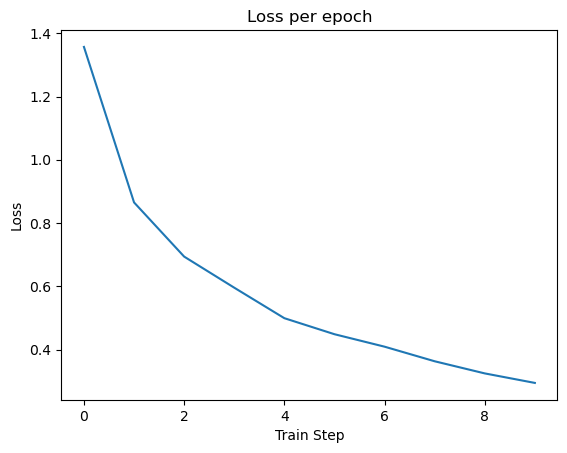

In [128]:
def visualize_loss(losses): 
    """
    Uses Matplotlib to visualize the losses of our model.
    :param losses: list of loss data stored from train. Can use the model's loss_list 
    field 

    NOTE: DO NOT EDIT

    :return: doesn't return anything, a plot should pop-up 
    """
    x = [i for i in range(len(losses))]
    plt.plot(x, losses)
    plt.title('Loss per epoch')
    plt.xlabel('Train Step')
    plt.ylabel('Loss')
    plt.show()

visualize_loss(m.history['loss'])

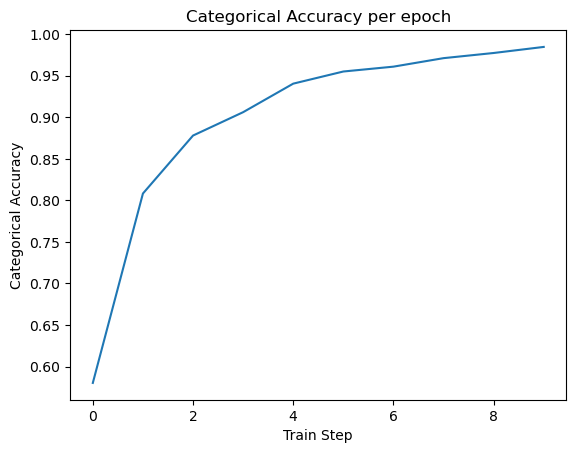

In [129]:
def visualize_cat_acc(accs): 
    """
    Uses Matplotlib to visualize the accuracy of our model.
    :param accs: list of accuracy data stored from train. Can use the model's acc_list 
    field 

    NOTE: DO NOT EDIT

    :return: doesn't return anything, a plot should pop-up 
    """
    x = [i for i in range(len(accs))]
    plt.plot(x, accs)
    plt.title('Categorical Accuracy per epoch')
    plt.xlabel('Train Step')
    plt.ylabel('Categorical Accuracy')
    plt.show()

visualize_cat_acc(m.history['categorical_accuracy'])

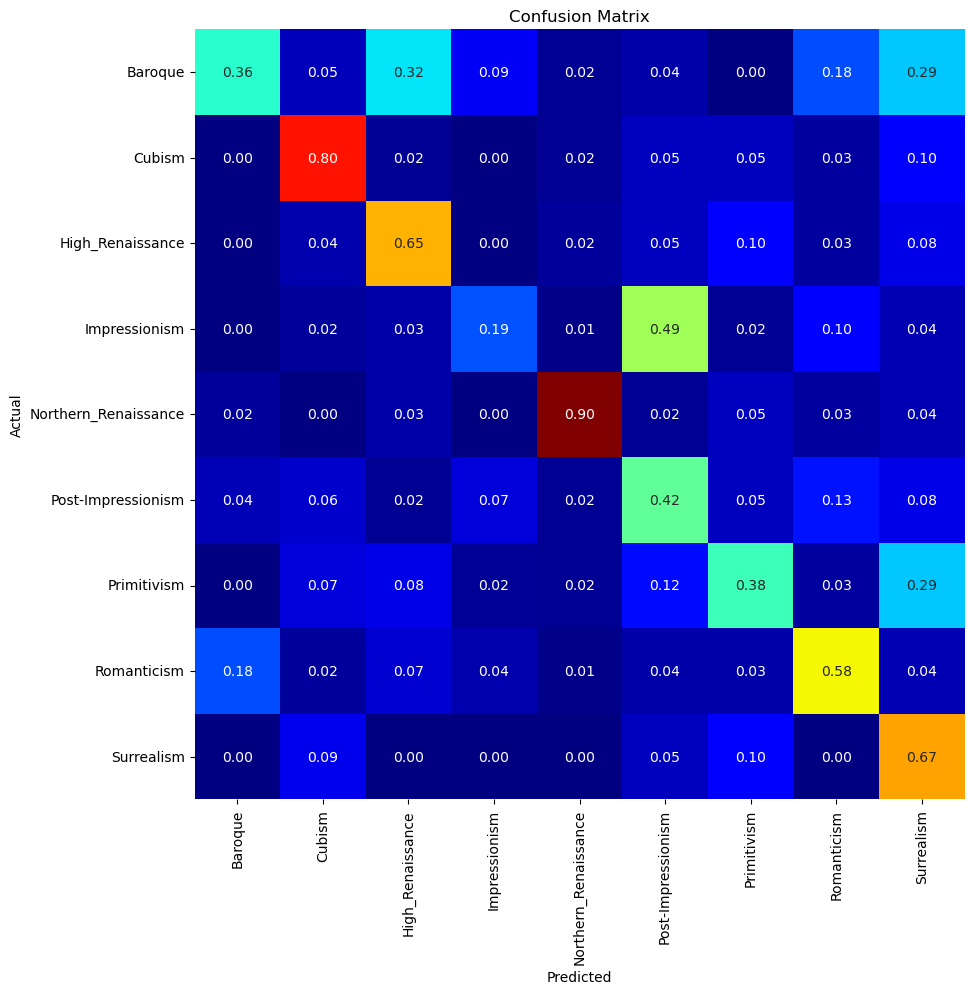

Classification Report:
                      precision    recall  f1-score   support

             Baroque       0.60      0.36      0.45        94
              Cubism       0.69      0.80      0.74        81
    High_Renaissance       0.53      0.65      0.59        60
       Impressionism       0.45      0.19      0.26        54
Northern_Renaissance       0.90      0.90      0.90       125
  Post-Impressionism       0.33      0.42      0.37        57
         Primitivism       0.49      0.38      0.43        60
         Romanticism       0.53      0.58      0.56        77
          Surrealism       0.41      0.67      0.50        48

            accuracy                           0.59       656
           macro avg       0.55      0.55      0.53       656
        weighted avg       0.59      0.59      0.58       656



In [145]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = genre_names

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=genre_names))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [140]:
def get_classification_report(model, generator, n_classes):
    """
    Creates a classification report for the model on the given generator.
    :param model: the model to test
    :param generator: the generator to test on
    :param n_classes: the number of classes in the model
    :return: a classification report
    """
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    return classification_report(y_true, y_pred, target_names=genre_names)

print(get_classification_report(model, valid_generator, n_classes))

                      precision    recall  f1-score   support

             Baroque       0.08      0.05      0.06        99
              Cubism       0.16      0.17      0.17        87
    High_Renaissance       0.08      0.10      0.09        60
       Impressionism       0.07      0.03      0.04        68
Northern_Renaissance       0.20      0.21      0.21       136
  Post-Impressionism       0.06      0.08      0.07        52
         Primitivism       0.04      0.03      0.04        61
         Romanticism       0.13      0.13      0.13        77
          Surrealism       0.03      0.06      0.04        48

            accuracy                           0.11       688
           macro avg       0.09      0.10      0.09       688
        weighted avg       0.11      0.11      0.11       688

